<a href="https://colab.research.google.com/github/jharri27/Calculating-Optimal-Airfare-and-Delay-Data/blob/master/Group_4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary Setup and Loading of Data

 Package Setup

In [0]:
import pandas as pd  # data frame operations
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from fbprophet import Prophet


Loading Data

In [0]:
#loading of Data
#Average Delay data by route (for example DFW to Den - delayed flights only)
Delays = pd.read_csv("FlightDataforDen.csv")
Pricing = pd.read_csv("PricingData.csv")
#Airlines = pd.read_csv("AirlineCodes.csv")

print(len(Pricing))
print(len(Delays))

90021
77239


Scrubbing of Data/Drop Values

In [0]:

Pricing = Pricing.drop(['citymarketid_1', 'citymarketid_2', 'nsmiles', 'passengers', 'carrier_lg', 'large_ms', 'fare_lg', 'carrier_low', 'lf_ms',	'fare_low',	'table_1_flag', 'Geocoded_City1',	'Geocoded_City2'], axis=1)
print(Pricing.head())
print(len(Pricing))


   Year  quarter                                city1  \
0  2009        2        Miami, FL (Metropolitan Area)   
1  2000        4      Atlanta, GA (Metropolitan Area)   
2  2007        4  Los Angeles, CA (Metropolitan Area)   
3  2004        4                     Indianapolis, IN   
4  2008        4                Dallas/Fort Worth, TX   

                      city2    fare  
0             Rochester, NY  151.46  
1           Kansas City, MO  172.83  
2        Salt Lake City, UT  135.24  
3  Minneapolis/St. Paul, MN  206.78  
4               Seattle, WA  242.74  
90021


Limiting Data to 2013-2017

In [0]:

#Setup to filter the Pricing data for only flights originating in 2013-2017, from Albany, Albuerquerque, Boston, Austin, DFW and to Denver
dest = ['Denver, CO']
years = [2013,2014,2015,2016,2017]
key_cities = ['Albany, NY', 'Albuquerque, NM','Austin, TX', 'Dallas/Fort Worth, TX', 'Boston, MA (Metropolitan Area)']
Pricing=Pricing[Pricing['city2'].isin(dest)]
print(len(Pricing))
Pricing=Pricing[Pricing['city1'].isin(key_cities)]
print(len(Pricing))
Pricing=Pricing[Pricing['Year'].isin(years)]
print(len(Pricing))
print(Pricing.head(n=100))
print(Pricing.tail(n=100))



1112
381
89
       Year  quarter                           city1       city2    fare
1578   2013        3                      Albany, NY  Denver, CO  294.71
4132   2014        1                      Austin, TX  Denver, CO  166.26
4884   2014        4                 Albuquerque, NM  Denver, CO  167.14
7496   2014        4  Boston, MA (Metropolitan Area)  Denver, CO  260.27
14350  2014        3           Dallas/Fort Worth, TX  Denver, CO  155.82
18732  2013        3                 Albuquerque, NM  Denver, CO  129.15
19809  2013        4           Dallas/Fort Worth, TX  Denver, CO  161.15
20698  2013        2           Dallas/Fort Worth, TX  Denver, CO  150.49
23241  2014        3  Boston, MA (Metropolitan Area)  Denver, CO  273.03
23724  2013        2  Boston, MA (Metropolitan Area)  Denver, CO  239.31
26666  2014        1           Dallas/Fort Worth, TX  Denver, CO  165.49
28555  2014        3                      Austin, TX  Denver, CO  160.91
29400  2013        3                   

Pricing Data Group by

In [0]:

#Pricing_aggDF = Pricing.groupby(['Year', 'quarter',  'city1', 'city2'])['fare'].mean()
Pricing_aggDF=Pricing.groupby(['Year','quarter','city1','city2'], as_index=False).agg({'fare':'mean'})
Pricing_aggDF


Pricing_aggDF.columns = ['YEAR','QUARTER','ORIGIN_CITY_NAME','DEST_CITY_NAME', 'FARES']
print(Pricing_aggDF.head())
len(Pricing_aggDF)



   YEAR  QUARTER                ORIGIN_CITY_NAME DEST_CITY_NAME   FARES
0  2013        1                 Albuquerque, NM     Denver, CO  122.91
1  2013        1                      Austin, TX     Denver, CO  162.15
2  2013        1  Boston, MA (Metropolitan Area)     Denver, CO  230.13
3  2013        1           Dallas/Fort Worth, TX     Denver, CO  152.27
4  2013        2                 Albuquerque, NM     Denver, CO  111.91


89

In [0]:

delays_aggDF = Delays.groupby(['YEAR','QUARTER','MONTH','OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID','ORIGIN_CITY_NAME','DEST_AIRPORT_ID','DEST_CITY_NAME'], as_index=False).agg({'DEP_DELAY':'mean','DEP_DEL15':'mean','ARR_DELAY':'mean','ARR_DEL15':'mean', 'CARRIER_DELAY':'mean','WEATHER_DELAY':'mean','NAS_DELAY':'mean','SECURITY_DELAY':'mean', 'LATE_AIRCRAFT_DELAY':'mean'})
print(delays_aggDF.head())
print(len(delays_aggDF))
delays_aggDF.to_csv("delays_aggDF.csv")
Fares_DelaysDF = pd.merge(Pricing_aggDF,delays_aggDF, how='inner', on=['YEAR','QUARTER','ORIGIN_CITY_NAME','DEST_CITY_NAME'])

   YEAR  QUARTER  MONTH OP_UNIQUE_CARRIER  ORIGIN_AIRPORT_ID  \
0  2013        1      1                AA              11298   
1  2013        1      1                B6              10721   
2  2013        1      1                EV              10140   
3  2013        1      1                EV              11259   
4  2013        1      1                EV              11298   

                 ORIGIN_CITY_NAME  DEST_AIRPORT_ID DEST_CITY_NAME  DEP_DELAY  \
0           Dallas/Fort Worth, TX            11292     Denver, CO   9.754902   
1  Boston, MA (Metropolitan Area)            11292     Denver, CO  10.206897   
2                 Albuquerque, NM            11292     Denver, CO  -2.285714   
3                      Dallas, TX            11292     Denver, CO  32.000000   
4           Dallas/Fort Worth, TX            11292     Denver, CO  11.411765   

   DEP_DEL15  ARR_DELAY  ARR_DEL15  CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  \
0   0.222222   2.790850   0.183007       2.944444      

Merging the Data together (Delays  and Pricing)

In [0]:
print(Fares_DelaysDF.head())
print(len(Fares_DelaysDF))
Fares_DelaysDF.to_csv("Fares_DelaysDF.csv")

   YEAR  QUARTER ORIGIN_CITY_NAME DEST_CITY_NAME   FARES  MONTH  \
0  2013        1  Albuquerque, NM     Denver, CO  122.91      1   
1  2013        1  Albuquerque, NM     Denver, CO  122.91      1   
2  2013        1  Albuquerque, NM     Denver, CO  122.91      1   
3  2013        1  Albuquerque, NM     Denver, CO  122.91      1   
4  2013        1  Albuquerque, NM     Denver, CO  122.91      2   

  OP_UNIQUE_CARRIER  ORIGIN_AIRPORT_ID  DEST_AIRPORT_ID  DEP_DELAY  DEP_DEL15  \
0                EV              10140            11292  -2.285714   0.142857   
1                F9              10140            11292   7.800000   0.200000   
2                OO              10140            11292   9.611111   0.250000   
3                WN              10140            11292   4.142857   0.142857   
4                EV              10140            11292   7.470588   0.235294   

   ARR_DELAY  ARR_DEL15  CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  \
0  -3.142857   0.142857       0.000000    

**Create City Specific Data Frames **



In [0]:
DFWT_DF = Fares_DelaysDF[Fares_DelaysDF['ORIGIN_CITY_NAME'] == 'Dallas/Fort Worth, TX']
ALBQ_DF = Fares_DelaysDF[Fares_DelaysDF['ORIGIN_CITY_NAME'] == 'Albuquerque, NM']
AUST_DF = Fares_DelaysDF[Fares_DelaysDF['ORIGIN_CITY_NAME'] == 'Austin, TX']
BOST_DF = Fares_DelaysDF[Fares_DelaysDF['ORIGIN_CITY_NAME'] == 'Boston, MA (Metropolitan Area)']
FARE_DELAY_NOALB_DF = Fares_DelaysDF[Fares_DelaysDF['ORIGIN_CITY_NAME'] != 'Albany, NY']

Fares_DelaysDF['Delay']=np.where(Fares_DelaysDF['DEP_DELAY']>=0, 'yes','no')
Fares_DelaysDF.head()

,YEAR,QUARTER,ORIGIN_CITY_NAME,DEST_CITY_NAME,FARES,MONTH,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Delay
0,2013,1,"Albuquerque, NM","Denver, CO",122.91,1,EV,10140,11292,-2.285714,0.142857,-3.142857,0.142857,0.000000,0.000000,0.142857,0.0,2.428571,no
1,2013,1,"Albuquerque, NM","Denver, CO",122.91,1,F9,10140,11292,7.800000,0.200000,5.600000,0.200000,0.000000,0.000000,0.000000,0.0,7.400000,yes
2,2013,1,"Albuquerque, NM","Denver, CO",122.91,1,OO,10140,11292,9.611111,0.250000,7.805556,0.222222,0.166667,0.000000,0.388889,0.0,9.805556,yes
3,2013,1,"Albuquerque, NM","Denver, CO",122.91,1,WN,10140,11292,4.142857,0.142857,1.666667,0.154762,0.261905,0.166667,2.452381,0.0,1.845238,yes
4,2013,1,"Albuquerque, NM","Denver, CO",122.91,2,EV,10140,11292,7.470588,0.235294,6.470588,0.235294,3.176471,0.000000,1.764706,0.0,5.647059,yes



#Summary Statistics 

In [0]:
#Summary Statistics - All Data
print ('Dataframe Data Summary Statistics - All Data')

min1 = round(np.min(Fares_DelaysDF['FARES']))
min2 = format(min1,',')
print ('Min of Airfares = ' + min2)

max1 = round(np.max(Fares_DelaysDF['FARES']))
max2 = format(max1,',')
print ('Max of Airfares = ' + max2)

mean1 = round(np.mean(Fares_DelaysDF['FARES']))
mean2 = format(mean1,',')
print ('Mean of Airfares = ' + mean2)

med1 = round(np.median(Fares_DelaysDF['FARES']))
med2 = format(med1,',')
print ('Median of Airfares = ' + med2)





Dataframe Data Summary Statistics - All Data
Min of Airfares = 112.0
Max of Airfares = 306.0
Mean of Airfares = 176.0
Median of Airfares = 162.0


### **Descriptive Plots**







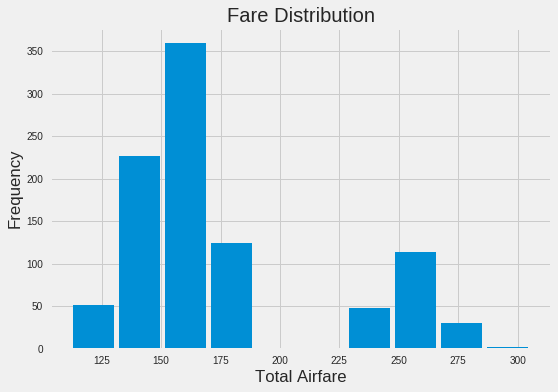

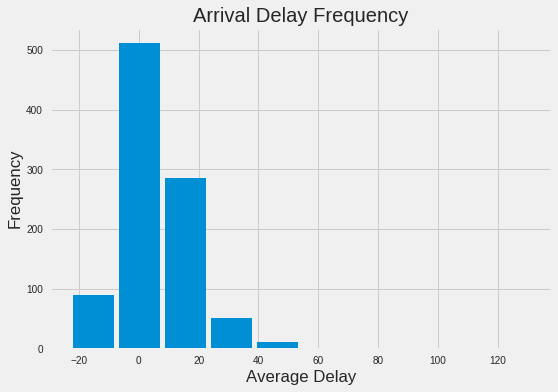

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


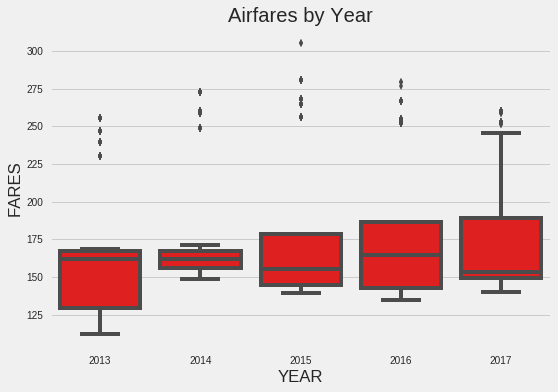

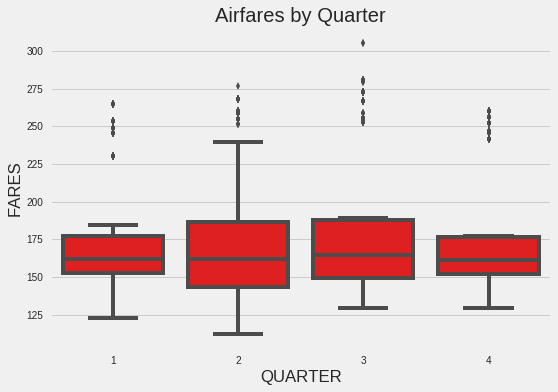

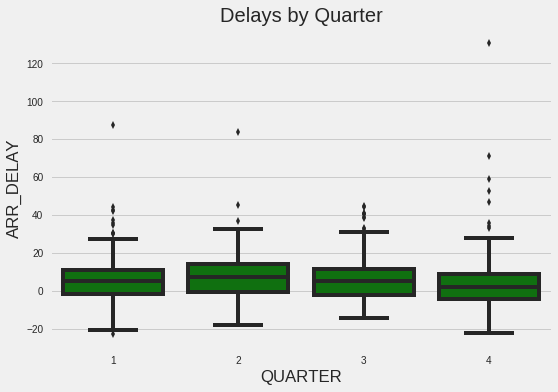

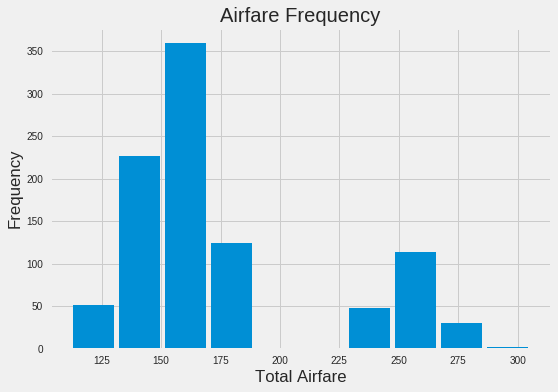

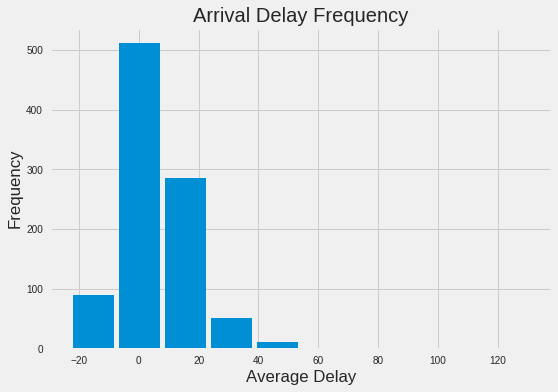

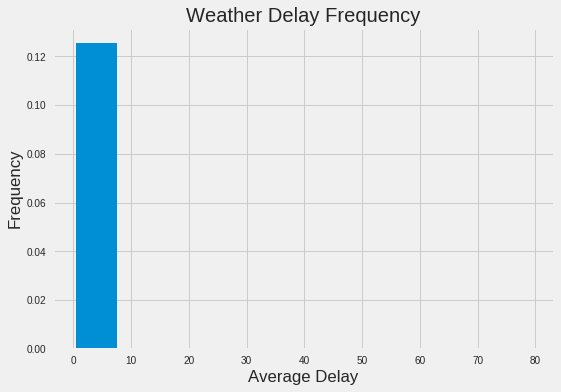

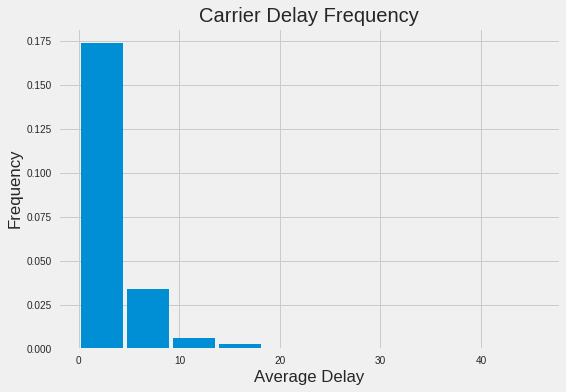

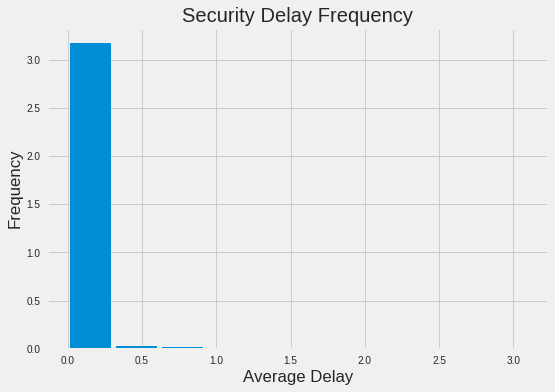

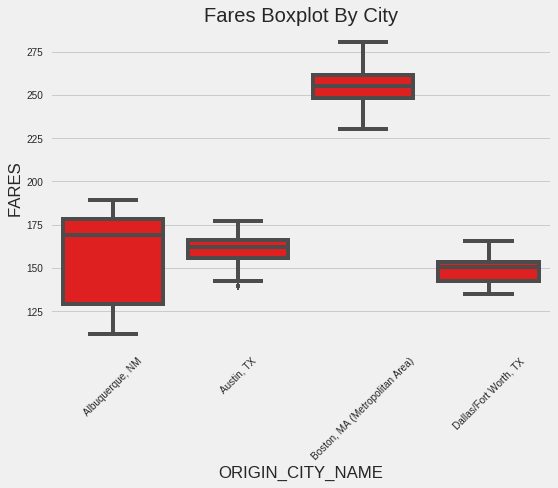

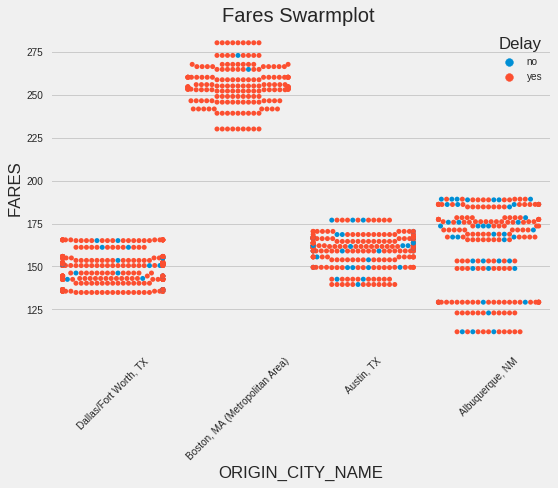

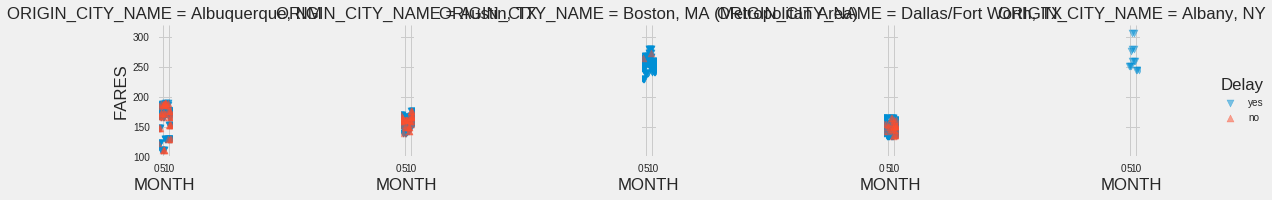

In [0]:
#CREATE A HISTOGRAM OF Fare distribution and Summary Boxplots
plt.hist(Fares_DelaysDF['FARES'], normed = False, stacked = False, rwidth = .9)
plt.title ('Fare Distribution')
plt.xlabel('Total Airfare')
plt.ylabel('Frequency')
plt.legend();
plt.show() 



#CREATE A HISTOGRAM OF Departure Delay distribution
plt.hist(Fares_DelaysDF['ARR_DELAY'], normed = False, stacked = False, rwidth = .9)
plt.title("Arrival Delay Frequency")
plt.xlabel('Average Delay')
plt.ylabel('Frequency')
plt.legend();
plt.show() 

#CREATE A BOXPLOT 
ax=sns.boxplot(x="YEAR", y="FARES", data=Fares_DelaysDF, color = "red");
plt.title("Airfares by Year")
plt.legend();
plt.show()


#CREATE A BOXPLOT 
ax=sns.boxplot(x="QUARTER", y="FARES", data=Fares_DelaysDF, color = "red");
plt.title("Airfares by Quarter")
plt.legend();
plt.show()


#CREATE A BOXPLOT 
ax=sns.boxplot(x="QUARTER", y="ARR_DELAY", data=Fares_DelaysDF, color = "green");
plt.title("Delays by Quarter")
plt.legend();
plt.show()

#CREATE A HISTOGRAM OF Fare distribution
plt.hist(Fares_DelaysDF['FARES'], normed = False, stacked = False, rwidth = .9)
plt.title("Airfare Frequency")
plt.xlabel('Total Airfare')
plt.ylabel('Frequency')
plt.legend();
plt.show() 


#CREATE A HISTOGRAM OF Departure Delay distribution
plt.hist(Fares_DelaysDF['ARR_DELAY'], normed = False, stacked = False, rwidth = .9)
plt.title("Arrival Delay Frequency")
plt.xlabel('Average Delay')
plt.ylabel('Frequency')
plt.legend();
plt.show() 


#plt.hist(df['distance'].dropna().values)
#CREATE A HISTOGRAM OF Weather Delay distribution
plt.hist(Fares_DelaysDF['WEATHER_DELAY'].dropna().values, normed = True, stacked = False, rwidth = .9)
plt.title("Weather Delay Frequency")
plt.xlabel('Average Delay')
plt.ylabel('Frequency')
plt.legend();
plt.show() 

#CREATE A HISTOGRAM OF Carrier Delay distribution
plt.hist(Fares_DelaysDF['CARRIER_DELAY'].dropna().values, normed = True, stacked = False, rwidth = .9)
plt.title("Carrier Delay Frequency")
plt.xlabel('Average Delay')
plt.ylabel('Frequency')
plt.legend();
plt.show() 

#CREATE A HISTOGRAM OF Security Delay distribution
plt.hist(Fares_DelaysDF['SECURITY_DELAY'].dropna().values, normed = True, stacked = False, rwidth = .9)
plt.title("Security Delay Frequency")
plt.xlabel('Average Delay')
plt.ylabel('Frequency')
plt.legend();
plt.show() 

#CREATE A BOXPLOT OF Fares by City
ax=sns.boxplot(x="ORIGIN_CITY_NAME", y="FARES", data=FARE_DELAY_NOALB_DF, color = "red");
plt.title("Fares Boxplot By City")
plt.xticks(rotation=45)
plt.legend();
plt.show()

#CREATE A SWARMPLOT OF Fares by City

ordered_city_names = (sorted(set(FARE_DELAY_NOALB_DF['ORIGIN_CITY_NAME']), reverse = True))
plt.title("Fares Swarmplot ")
sns.swarmplot(y="FARES", x="ORIGIN_CITY_NAME",hue="Delay", 
            data=Fares_DelaysDF, order=ordered_city_names)
plt.xticks(rotation=45)
plt.show()

#CREATE A Scatterplot OF Delays by Fares
g = sns.FacetGrid(Fares_DelaysDF, col="ORIGIN_CITY_NAME", hue="Delay", 
                                 hue_order=["yes", "no"],
                   hue_kws=dict(marker=["v", "^"]))
g.map(plt.scatter, "MONTH", "FARES", alpha=.5)
g.add_legend();
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


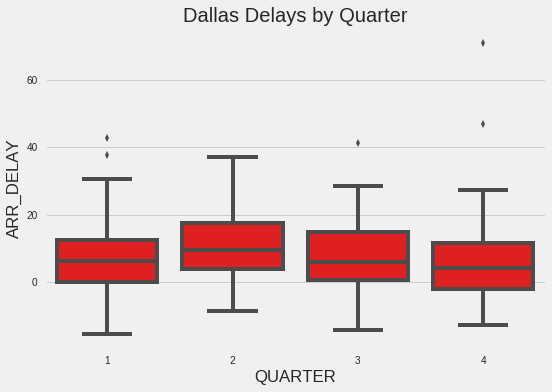

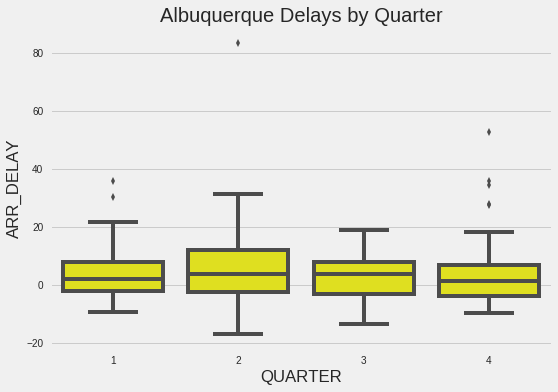

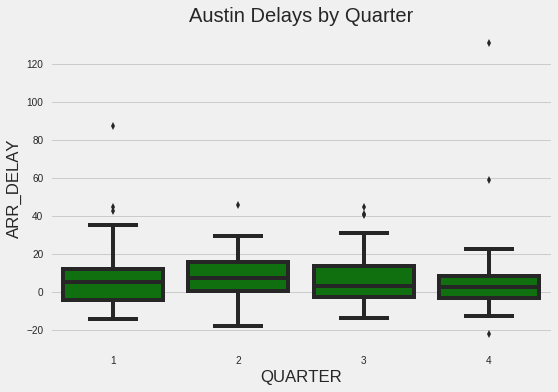

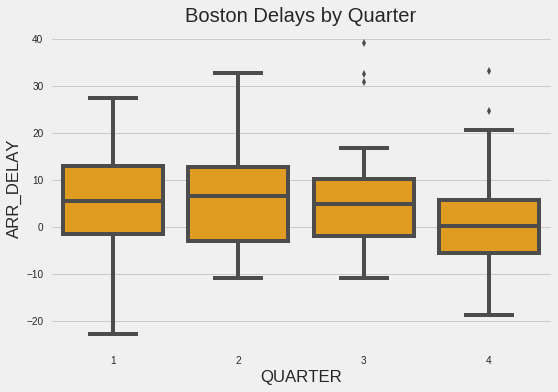

In [0]:
## Delays by Departure City


#CREATE A BOXPLOT 
ax=sns.boxplot(x="QUARTER", y="ARR_DELAY", data=DFWT_DF, color = "red");
plt.title("Dallas Delays by Quarter")
plt.legend();
plt.show()

#CREATE A BOXPLOT 
ax=sns.boxplot(x="QUARTER", y="ARR_DELAY", data=ALBQ_DF, color = "yellow");
plt.title("Albuquerque Delays by Quarter")
plt.legend();
plt.show()

#CREATE A BOXPLOT 
ax=sns.boxplot(x="QUARTER", y="ARR_DELAY", data=AUST_DF, color = "green");
plt.title("Austin Delays by Quarter")
plt.legend();
plt.show()
#CREATE A BOXPLOT 
ax=sns.boxplot(x="QUARTER", y="ARR_DELAY", data=BOST_DF, color = "orange");
plt.title("Boston Delays by Quarter")
plt.legend();
plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


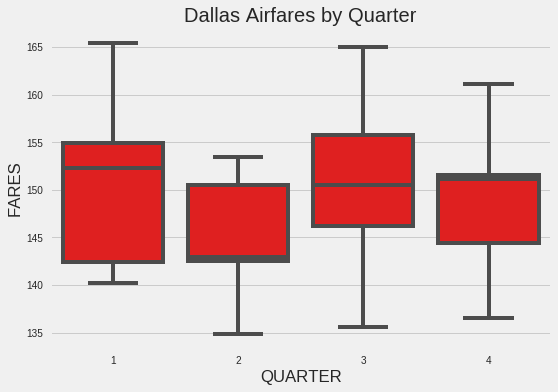

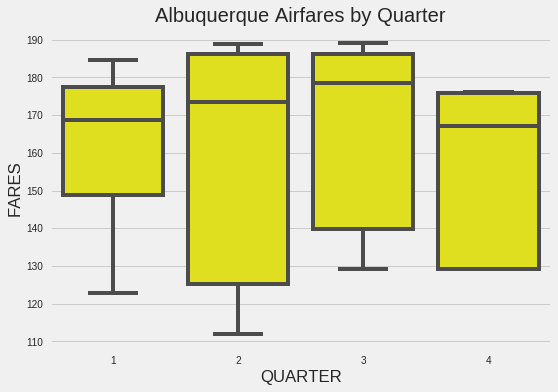

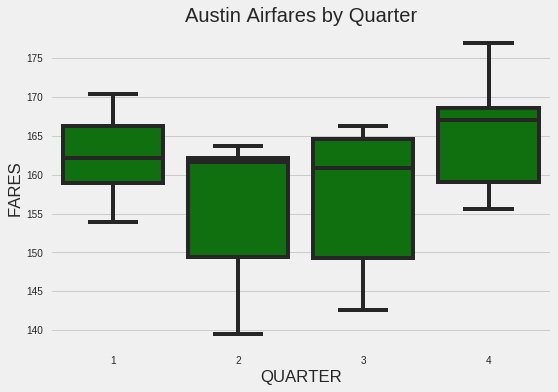

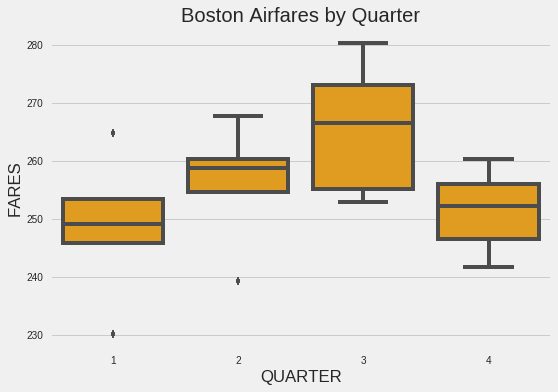

In [0]:
# Airfares by Departure City

#CREATE A BOXPLOT 
ax=sns.boxplot(x="QUARTER", y="FARES", data=DFWT_DF, color = "red");
plt.title("Dallas Airfares by Quarter")
plt.legend();
plt.show()

#CREATE A BOXPLOT 
ax=sns.boxplot(x="QUARTER", y="FARES", data=ALBQ_DF, color = "yellow");
plt.title("Albuquerque Airfares by Quarter")
plt.legend();
plt.show()

#CREATE A BOXPLOT 
ax=sns.boxplot(x="QUARTER", y="FARES", data=AUST_DF, color = "green");
plt.title("Austin Airfares by Quarter")
plt.legend();
plt.show()
#CREATE A BOXPLOT 
ax=sns.boxplot(x="QUARTER", y="FARES", data=BOST_DF, color = "orange");
plt.title("Boston Airfares by Quarter")
plt.legend();
plt.show()



In [0]:
#Plotting Prices
Pricing_aggDF['PERIOD'] = Pricing_aggDF['YEAR'].astype(str) +"Q"+ Pricing_aggDF['QUARTER'].astype(str)
Pricing_aggDF.head()


,YEAR,QUARTER,ORIGIN_CITY_NAME,DEST_CITY_NAME,FARES,PERIOD
0,2013,1,"Albuquerque, NM","Denver, CO",122.91,2013Q1
1,2013,1,"Austin, TX","Denver, CO",162.15,2013Q1
2,2013,1,"Boston, MA (Metropolitan Area)","Denver, CO",230.13,2013Q1
3,2013,1,"Dallas/Fort Worth, TX","Denver, CO",152.27,2013Q1
4,2013,2,"Albuquerque, NM","Denver, CO",111.91,2013Q2


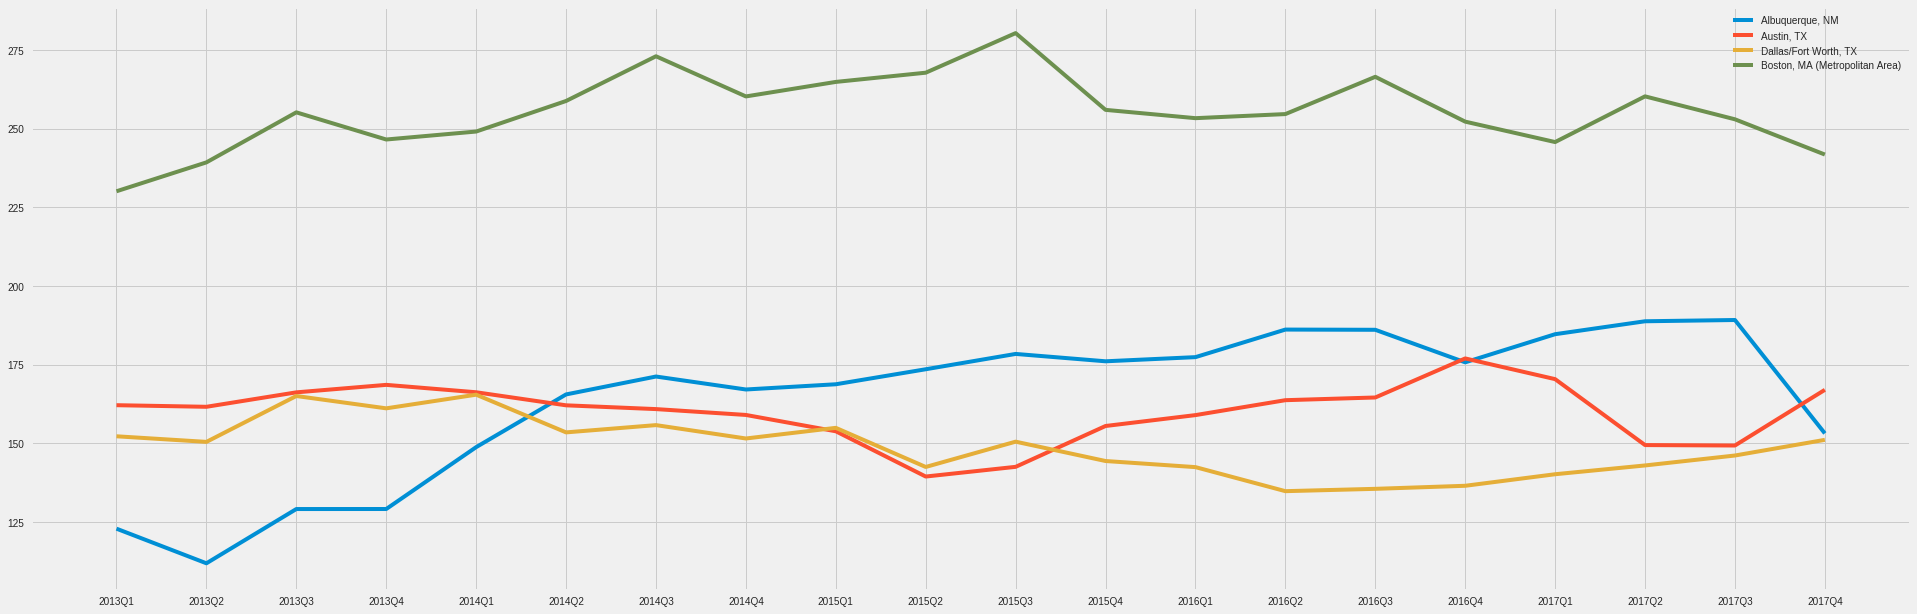

In [0]:

df = Pricing_aggDF.pivot('PERIOD', columns='ORIGIN_CITY_NAME', values='FARES')
df.head()
df['Period'] = df.index
df = df.reset_index(drop=True)
df.head()
df.index.rename("PERIOD", inplace=False)
df.head()
axs = plt.subplots(figsize=(30,10))
plt.plot('Period', 'Albuquerque, NM', data=df)
plt.plot('Period', 'Austin, TX', data=df)
plt.plot('Period', 'Dallas/Fort Worth, TX', data=df)
plt.plot('Period', 'Boston, MA (Metropolitan Area)', data=df)
plt.legend()
plt.show()

In [0]:
#delays_aggDF.head()
delays_aggDF['PERIOD'] = delays_aggDF['YEAR'].astype(str) +"-0"+ delays_aggDF['MONTH'].astype(str)+"-01"
#delays_aggDF.head()
delays_aggDF['PERIOD'] = pd.to_datetime(delays_aggDF['PERIOD'])
#delays_aggDF.head()
delays_aggDF.set_index(delays_aggDF['PERIOD'], inplace=True) 
delays_aggDF.head()


,YEAR,QUARTER,MONTH,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,PERIOD
PERIOD,,,,,,,,,,,,,,,,,,
2013-01-01,2013,1,1,AA,11298,"Dallas/Fort Worth, TX",11292,"Denver, CO",9.754902,0.222222,2.790850,0.183007,2.944444,0.764706,0.718954,0.0,3.643791,2013-01-01
2013-01-01,2013,1,1,B6,10721,"Boston, MA (Metropolitan Area)",11292,"Denver, CO",10.206897,0.241379,13.948276,0.362069,5.862069,0.000000,7.879310,0.0,2.000000,2013-01-01
2013-01-01,2013,1,1,EV,10140,"Albuquerque, NM",11292,"Denver, CO",-2.285714,0.142857,-3.142857,0.142857,0.000000,0.000000,0.142857,0.0,2.428571,2013-01-01
2013-01-01,2013,1,1,EV,11259,"Dallas, TX",11292,"Denver, CO",32.000000,1.000000,28.000000,1.000000,0.000000,0.000000,0.000000,0.0,28.000000,2013-01-01
2013-01-01,2013,1,1,EV,11298,"Dallas/Fort Worth, TX",11292,"Denver, CO",11.411765,0.352941,6.647059,0.176471,4.529412,0.000000,1.647059,0.0,2.176471,2013-01-01


In [0]:
#delays_aggDF.set_index('PERIOD').groupby('ORIGIN_CITY_NAME').resample('Q').asfreq().drop(['OP_UNIQUE_CARRIER', 'index'], 1).reset_index())
#delays_aggDF

In [0]:
from fbprophet import Prophet
df = pd.read_csv("Fares_DelaysDF.csv")
plt.style.use('fivethirtyeight')

# Creating Fares Dataframe
df_fares = df
df_fares = df_fares.drop(['Unnamed: 0', 'DEST_CITY_NAME', 'QUARTER', 'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_DELAY', 'DEP_DEL15', 'ARR_DELAY', 'ARR_DEL15', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'], axis=1)
df_fares = df_fares.drop_duplicates(subset=None, keep='first', inplace=False)
df_fares['DAY'] = 1
df_fares['date'] = pd.to_datetime(df_fares[['DAY','MONTH','YEAR']])
df_fares = df_fares.drop(['YEAR', 'MONTH', 'DAY'], axis=1)



df_fares.head(10)

,ORIGIN_CITY_NAME,FARES,date
0,"Albuquerque, NM",122.91,2013-01-01
4,"Albuquerque, NM",122.91,2013-02-01
8,"Albuquerque, NM",122.91,2013-03-01
12,"Austin, TX",162.15,2013-01-01
16,"Austin, TX",162.15,2013-02-01
20,"Austin, TX",162.15,2013-03-01
24,"Boston, MA (Metropolitan Area)",230.13,2013-01-01
27,"Boston, MA (Metropolitan Area)",230.13,2013-02-01
30,"Boston, MA (Metropolitan Area)",230.13,2013-03-01
33,"Dallas/Fort Worth, TX",152.27,2013-01-01


Prophet Models - Fares

,y,ds
12,162.15,2013-01-01
16,162.15,2013-02-01
20,162.15,2013-03-01
61,161.64,2013-04-01
65,161.64,2013-05-01


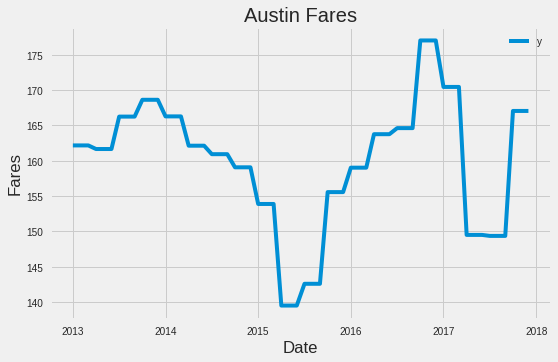

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


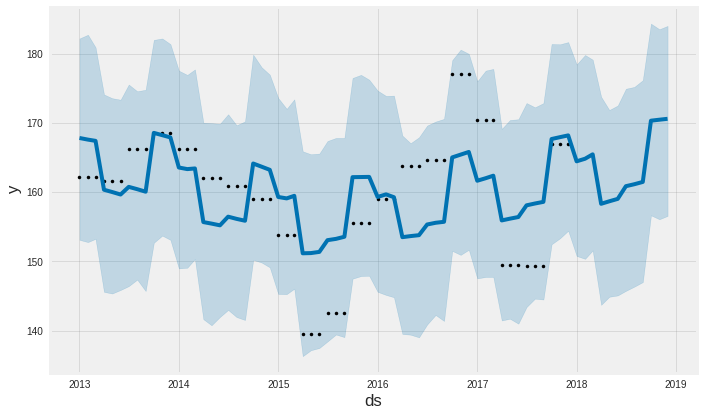

In [0]:
# Prophet Model - Austin Fare
austinFares = df_fares[df_fares['ORIGIN_CITY_NAME'] == "Austin, TX"]
austinFares = austinFares.drop(['ORIGIN_CITY_NAME'], axis = 1)
austinFares = austinFares.rename(columns={'FARES': 'y', 'date': 'ds'})

display(austinFares.head(5))

ax = austinFares.set_index('ds').plot(figsize=(8, 5))
ax.set_ylabel('Fares')
ax.set_xlabel('Date')
ax.set_title('Austin Fares')
plt.show()

p_modelausfares = Prophet(interval_width=0.95) #interval width is the confidence level
p_modelausfares.fit(austinFares)

future_datesausfares = p_modelausfares.make_future_dataframe(periods=12, freq='MS')
future_datesausfares.tail()

forecastausfares = p_modelausfares.predict(future_datesausfares)
forecastausfares[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

p_modelausfares.plot(forecastausfares, uncertainty=True);

,y,ds
0,122.91,2013-01-01
4,122.91,2013-02-01
8,122.91,2013-03-01
48,111.91,2013-04-01
52,111.91,2013-05-01


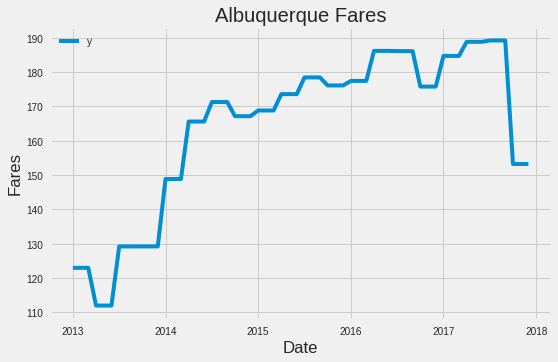

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


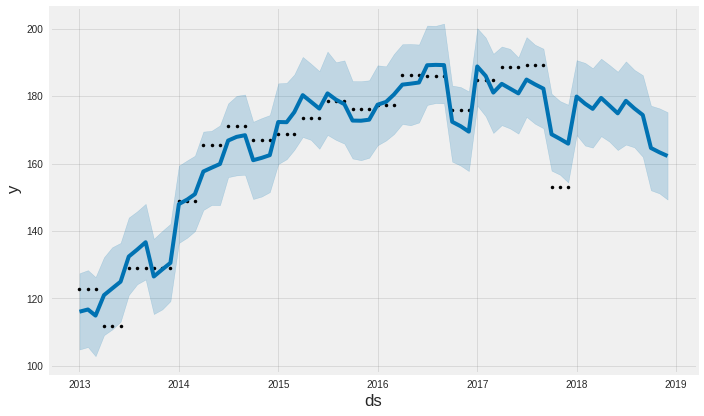

In [0]:
#abq prophet 
abqfares = df_fares[df_fares['ORIGIN_CITY_NAME'] == "Albuquerque, NM"]
abqfares = abqfares.drop(['ORIGIN_CITY_NAME'], axis = 1)
abqfares = abqfares.rename(columns={'FARES': 'y', 'date': 'ds'})

display(abqfares.head(5))

ax = abqfares.set_index('ds').plot(figsize=(8, 5))
ax.set_ylabel('Fares')
ax.set_xlabel('Date')
ax.set_title('Albuquerque Fares')
plt.show()

p_modelabqfares = Prophet(interval_width=0.95) #interval width is the confidence level
p_modelabqfares.fit(abqfares)

future_datesabqfares = p_modelabqfares.make_future_dataframe(periods=12, freq='MS')
future_datesabqfares.tail()

forecastabqfares = p_modelabqfares.predict(future_datesabqfares)
forecastabqfares[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

p_modelabqfares.plot(forecastabqfares, uncertainty=True);

,y,ds
33,152.27,2013-01-01
38,152.27,2013-02-01
43,152.27,2013-03-01
84,150.49,2013-04-01
89,150.49,2013-05-01


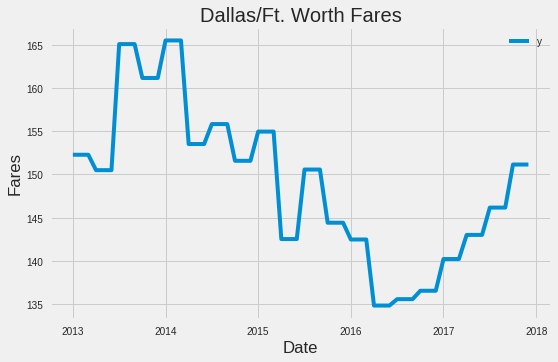

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


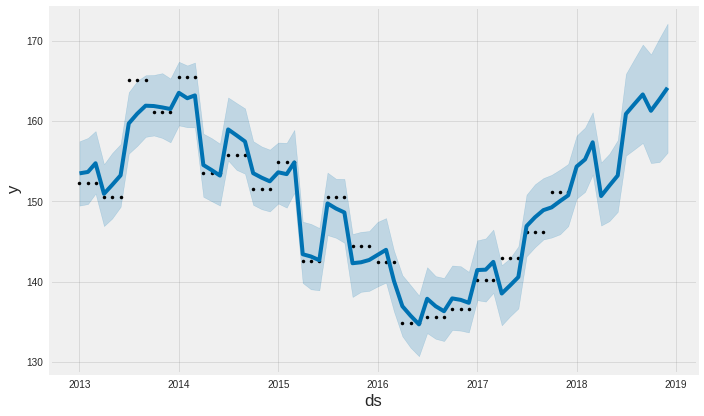

In [0]:
#dfw prophet
dfwfares = df_fares[df_fares['ORIGIN_CITY_NAME'] == "Dallas/Fort Worth, TX"]
dfwfares = dfwfares.drop(['ORIGIN_CITY_NAME'], axis = 1)
dfwfares = dfwfares.rename(columns={'FARES': 'y', 'date': 'ds'})

display(dfwfares.head(5))

ax = dfwfares.set_index('ds').plot(figsize=(8, 5))
ax.set_ylabel('Fares')
ax.set_xlabel('Date')
ax.set_title('Dallas/Ft. Worth Fares')
plt.show()

p_modeldfwfares = Prophet(interval_width=0.95) #interval width is the confidence level
p_modeldfwfares.fit(dfwfares)

future_datesdfwfares = p_modeldfwfares.make_future_dataframe(periods=12, freq='MS')
future_datesdfwfares.tail()

forecastdfwfares = p_modeldfwfares.predict(future_datesdfwfares)
forecastdfwfares[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

p_modeldfwfares.plot(forecastdfwfares, uncertainty=True);

,y,ds
24,230.13,2013-01-01
27,230.13,2013-02-01
30,230.13,2013-03-01
75,239.31,2013-04-01
78,239.31,2013-05-01


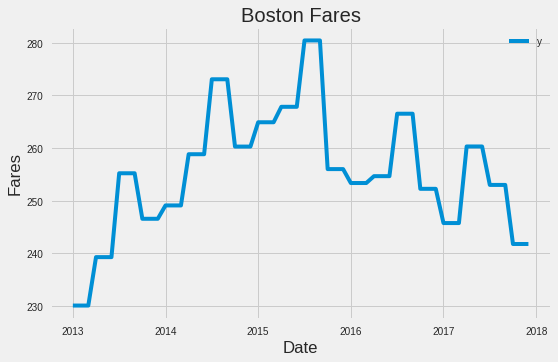

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


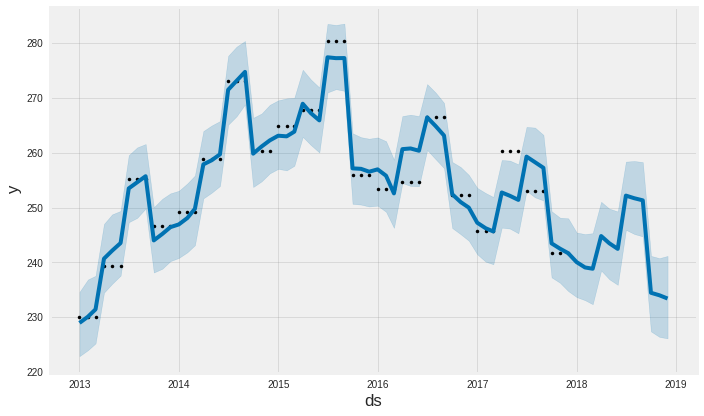

In [0]:
#bos fares
bosfares = df_fares[df_fares['ORIGIN_CITY_NAME'] == "Boston, MA (Metropolitan Area)"]
bosfares = bosfares.drop(['ORIGIN_CITY_NAME'], axis = 1)
bosfares = bosfares.rename(columns={'FARES': 'y', 'date': 'ds'})

display(bosfares.head(5))

ax = bosfares.set_index('ds').plot(figsize=(8, 5))
ax.set_ylabel('Fares')
ax.set_xlabel('Date')
ax.set_title('Boston Fares')
plt.show()

p_modelbosfares = Prophet(interval_width=0.95) #interval width is the confidence level
p_modelbosfares.fit(bosfares)

future_datesbosfares = p_modelbosfares.make_future_dataframe(periods=12, freq='MS')
future_datesbosfares.tail()

forecastbosfares = p_modelbosfares.predict(future_datesbosfares)
forecastbosfares[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

p_modelbosfares.plot(forecastbosfares, uncertainty=True);



In [0]:
# Creating Arrival Dataframe
df_arr = df
df_arr = df_arr.drop(['Unnamed: 0', 'DEST_CITY_NAME', 'QUARTER', 'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_DELAY', 'DEP_DEL15', 'FARES', 'ARR_DEL15', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'], axis=1)
df_arr = df_arr.drop_duplicates(subset=None, keep='first', inplace=False)
df_arr['DAY'] = 1
df_arr['date'] = pd.to_datetime(df_arr[['DAY','MONTH','YEAR']])
df_arr = df_arr.drop(['YEAR', 'MONTH', 'DAY'], axis=1)
df_arr.tail(10)

,ORIGIN_CITY_NAME,ARR_DELAY,date
945,"Dallas/Fort Worth, TX",1.220721,2017-11-01
946,"Dallas/Fort Worth, TX",-5.851852,2017-11-01
947,"Dallas/Fort Worth, TX",2.481481,2017-11-01
948,"Dallas/Fort Worth, TX",-1.000000,2017-11-01
949,"Dallas/Fort Worth, TX",-7.349515,2017-11-01
950,"Dallas/Fort Worth, TX",7.659919,2017-12-01
951,"Dallas/Fort Worth, TX",-2.280000,2017-12-01
952,"Dallas/Fort Worth, TX",2.680000,2017-12-01
953,"Dallas/Fort Worth, TX",20.235294,2017-12-01
954,"Dallas/Fort Worth, TX",-9.025974,2017-12-01


Prophet Models - Delays

,y,ds
12,6.622222,2013-01-01
13,87.333333,2013-01-01
14,-10.742857,2013-01-01
15,-4.409091,2013-01-01
16,13.904762,2013-02-01


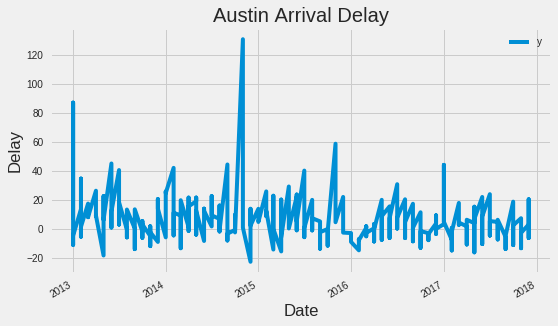

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


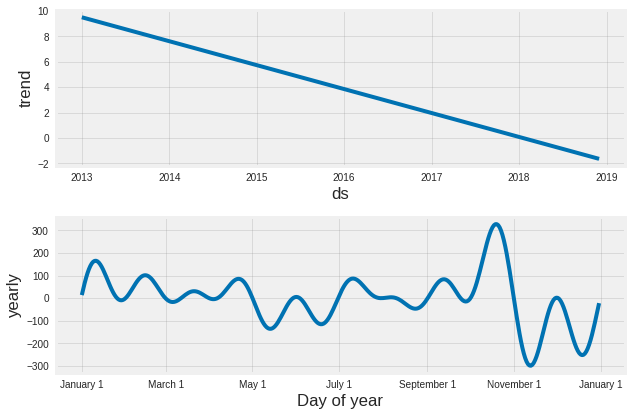

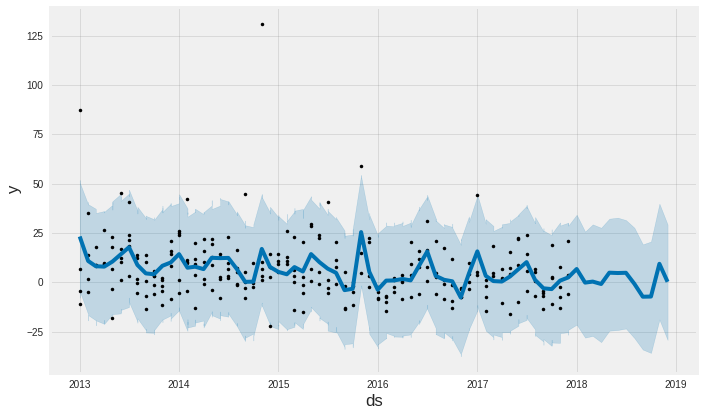

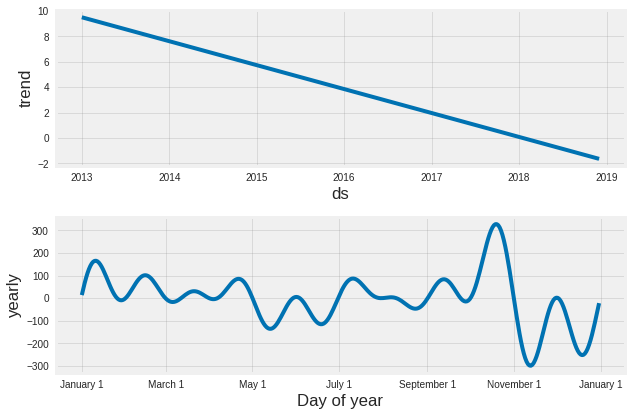

In [0]:

# Prophet Model - Austin Arr Delay
austinArr = df_arr[df_arr['ORIGIN_CITY_NAME'] == "Austin, TX"]
austinArr = austinArr.drop(['ORIGIN_CITY_NAME'], axis = 1)
austinArr = austinArr.rename(columns={'ARR_DELAY': 'y', 'date': 'ds'})

display(austinArr.head(5))

ax = austinArr.set_index('ds').plot(figsize=(8, 5))
ax.set_ylabel('Delay')
ax.set_xlabel('Date')
ax.set_title('Austin Arrival Delay')
plt.show()

p_modelaustin = Prophet(interval_width=0.95) #interval width is the confidence level
p_modelaustin.fit(austinArr)

future_datesaustin = p_modelaustin.make_future_dataframe(periods=12, freq='MS')
future_datesaustin.tail()

forecastaustin = p_modelaustin.predict(future_datesaustin)
forecastaustin[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

p_modelaustin.plot(forecastaustin, uncertainty=True);
p_modelaustin.plot_components(forecastaustin)



,y,ds
33,2.790850,2013-01-01
34,6.647059,2013-01-01
35,5.302521,2013-01-01
36,5.250000,2013-01-01
37,-2.802469,2013-01-01


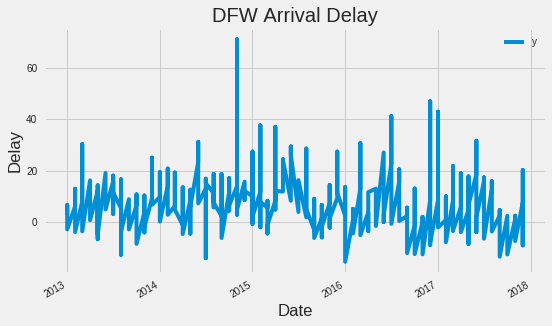

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


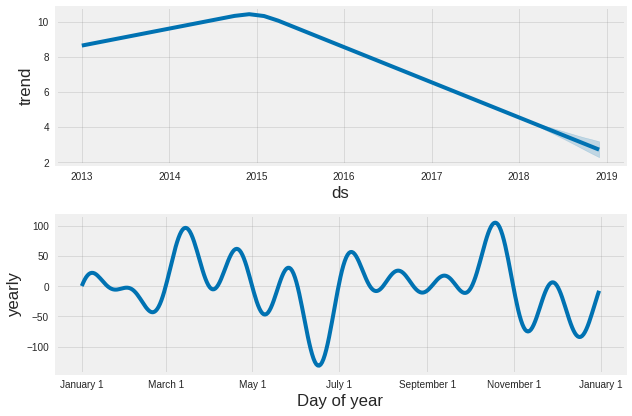

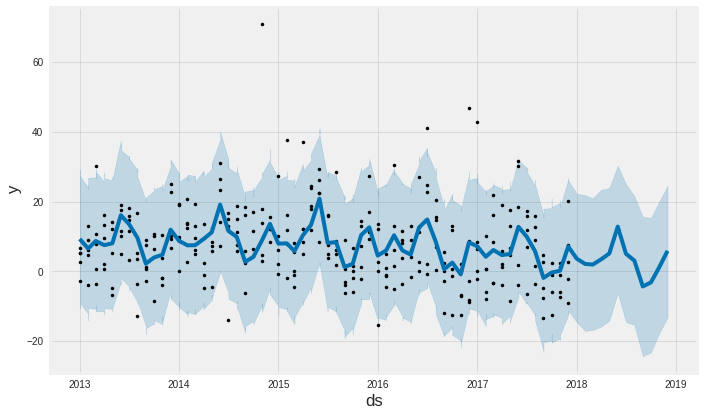

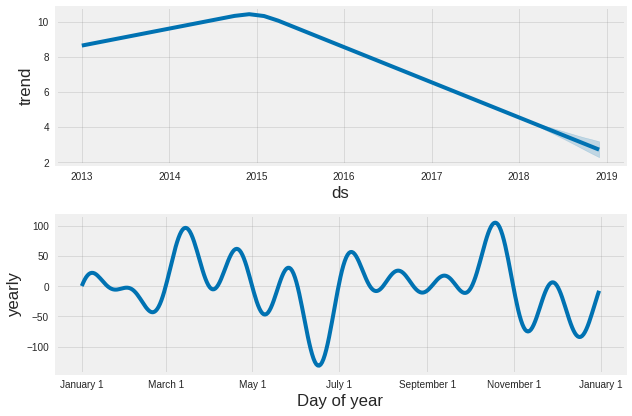

In [0]:
# Prophet Model - DFW Arr Delay
dfwArr = df_arr[df_arr['ORIGIN_CITY_NAME'] == "Dallas/Fort Worth, TX"]
dfwArr = dfwArr.drop(['ORIGIN_CITY_NAME'], axis = 1)
dfwArr = dfwArr.rename(columns={'ARR_DELAY': 'y', 'date': 'ds'})

display(dfwArr.head(5))

ax = dfwArr.set_index('ds').plot(figsize=(8, 5))
ax.set_ylabel('Delay')
ax.set_xlabel('Date')
ax.set_title('DFW Arrival Delay')
plt.show()

p_modeldfw = Prophet(interval_width=0.95) #interval width is the confidence level
p_modeldfw.fit(dfwArr)

future_datesdfw= p_modeldfw.make_future_dataframe(periods=12, freq='MS')
future_datesdfw.tail()

forecastdfw = p_modeldfw.predict(future_datesdfw)
forecastdfw[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

p_modeldfw.plot(forecastdfw, uncertainty=True);
p_modeldfw.plot_components(forecastdfw)




,y,ds
0,-3.142857,2013-01-01
1,5.600000,2013-01-01
2,7.805556,2013-01-01
3,1.666667,2013-01-01
4,6.470588,2013-02-01


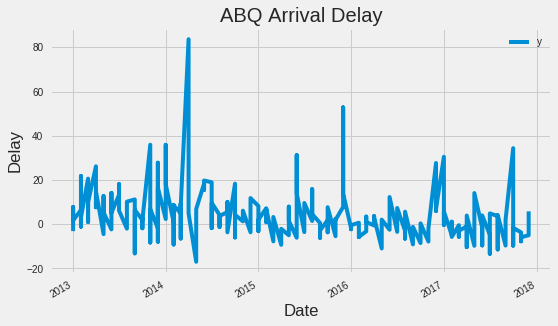

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


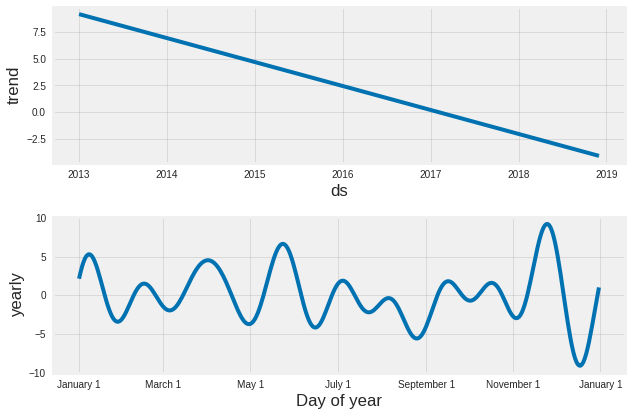

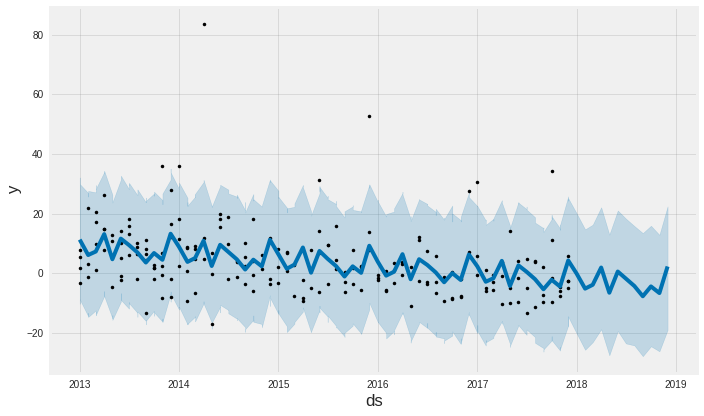

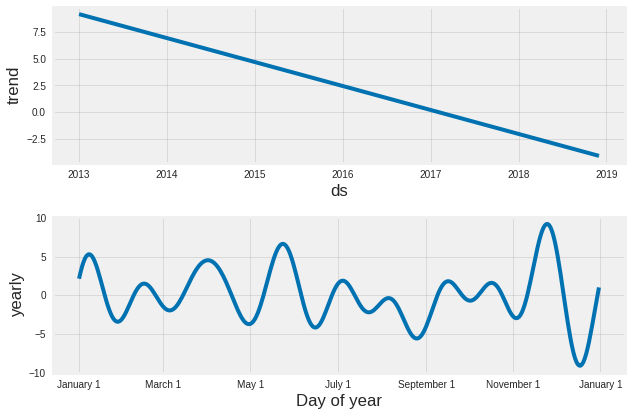

In [0]:
# Prophet Model - ABQ Arr Delay
abqArr = df_arr[df_arr['ORIGIN_CITY_NAME'] == "Albuquerque, NM"]
abqArr = abqArr.drop(['ORIGIN_CITY_NAME'], axis = 1)
abqArr = abqArr.rename(columns={'ARR_DELAY': 'y', 'date': 'ds'})

display(abqArr.head(5))

ax = abqArr.set_index('ds').plot(figsize=(8, 5))
ax.set_ylabel('Delay')
ax.set_xlabel('Date')
ax.set_title('ABQ Arrival Delay')
plt.show()

p_modelabq = Prophet(interval_width=0.95) #interval width is the confidence level
p_modelabq.fit(abqArr)

future_datesabq = p_modelabq.make_future_dataframe(periods=12, freq='MS')
future_datesabq.tail()

forecastabq = p_modelabq.predict(future_datesabq)
forecastabq[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

p_modelabq.plot(forecastabq, uncertainty=True);
p_modelabq.plot_components(forecastabq)



,y,ds
24,13.948276,2013-01-01
25,9.854839,2013-01-01
26,1.527778,2013-01-01
27,4.980392,2013-02-01
28,10.281250,2013-02-01


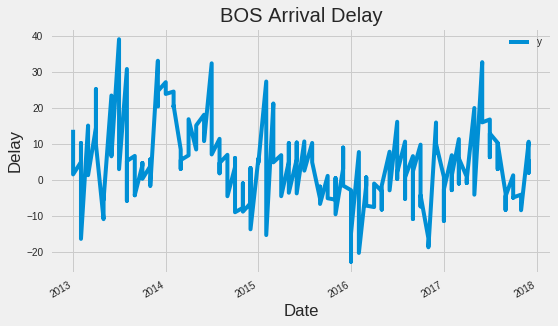

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


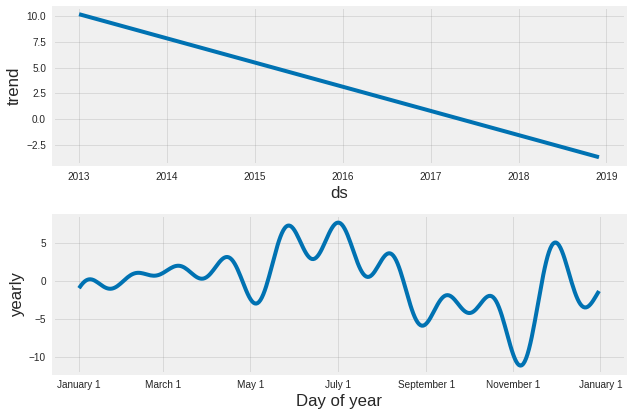

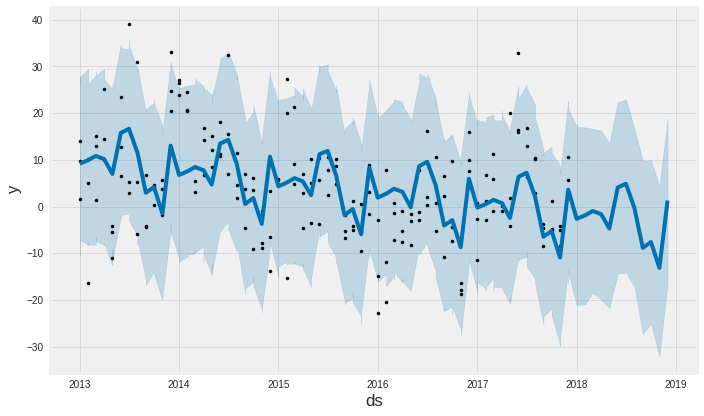

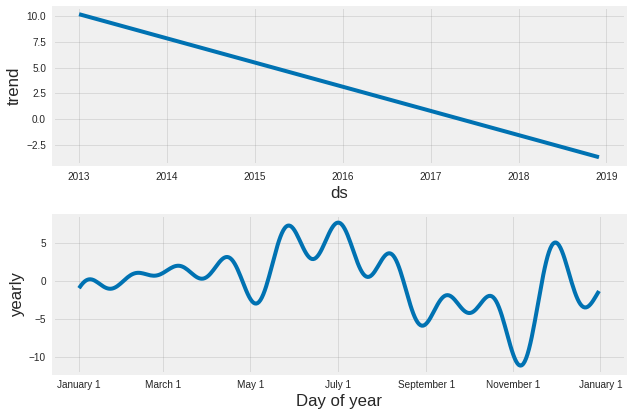

In [0]:
# Prophet Model - Bos Arr Delay
bosArr = df_arr[df_arr['ORIGIN_CITY_NAME'] == "Boston, MA (Metropolitan Area)"]
bosArr = bosArr.drop(['ORIGIN_CITY_NAME'], axis = 1)
bosArr = bosArr.rename(columns={'ARR_DELAY': 'y', 'date': 'ds'})

display(bosArr.head(5))

ax = bosArr.set_index('ds').plot(figsize=(8, 5))
ax.set_ylabel('Delay')
ax.set_xlabel('Date')
ax.set_title('BOS Arrival Delay')
plt.show()

p_modelBOSarr = Prophet(interval_width=0.95) #interval width is the confidence level
p_modelBOSarr.fit(bosArr)

future_datesbos= p_modelBOSarr.make_future_dataframe(periods=12, freq='MS')
future_datesbos.tail()

forecastBOS = p_modelBOSarr.predict(future_datesbos)
forecastBOS[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

p_modelBOSarr.plot(forecastBOS, uncertainty=True);
p_modelBOSarr.plot_components(forecastBOS)




In [0]:
#Plotting

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import logging

import numpy as np
import pandas as pd

from fbprophet.diagnostics import performance_metrics

logger = logging.getLogger('fbprophet')


try:
    from matplotlib import pyplot as plt
    from matplotlib.dates import MonthLocator, num2date
    from matplotlib.ticker import FuncFormatter
except ImportError:
    logger.error('Importing matplotlib failed. Plotting will not work.')


def plot1(
    m, m1, m2,m3, fcst, fcst1, fcst2,fcst3, ax=None, uncertainty=True, plot_cap=True, xlabel='Dates', ylabel='Delay in Mins',
    figsize=(10, 6)
):
    """Plot the Prophet forecast.
    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    figsize: Optional tuple width, height in inches.
    Returns
    -------
    A matplotlib figure.
    """
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds'].dt.to_pydatetime()
    fcst_1 = fcst1['ds'].dt.to_pydatetime()
    fcst_2 = fcst2['ds'].dt.to_pydatetime()
    fcst_3 = fcst3['ds'].dt.to_pydatetime()
    
    
     
  
  
    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.')
    ax.plot(fcst_t, fcst['yhat'], ls='-', c='#b24000')
    ax.plot(fcst_1, fcst1['yhat'], ls='-', c='#00b299')    
    ax.plot(fcst_2, fcst2['yhat'], ls='-', c='#000000') 
    ax.plot(fcst_3, fcst3['yhat'], ls='-', c='#8B008B') 
       
    

    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k')
        ax.plot(fcst_1, fcst1['cap'], ls='--', c='k')
        ax.plot(fcst_2, fcst2['cap'], ls='--', c='k', linestyle=':')
        ax.plot(fcst_3, fcst3['cap'], ls='--', c='k', linestyle=':')
    
    
    
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k')
        ax.plot(fcst_1, fcst1['floor'], ls='--', c='k')
        ax.plot(fcst_2, fcst2['floor'], ls='--', c='k',  linestyle=':')
        ax.plot(fcst_3, fcst3['floor'], ls='--', c='k',  linestyle=':')
             
          
          
          
        
    if uncertainty:
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'], color='#b24000', alpha=0.2)
        ax.fill_between(fcst_1, fcst1['yhat_lower'], fcst1['yhat_upper'], color='#00b299', alpha=0.2)
        ax.fill_between(fcst_2, fcst2['yhat_lower'], fcst2['yhat_upper'], color='#000000', alpha=0.2)
        ax.fill_between(fcst_2, fcst2['yhat_lower'], fcst2['yhat_upper'], color='#8B008B', alpha=0.2)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    return fig


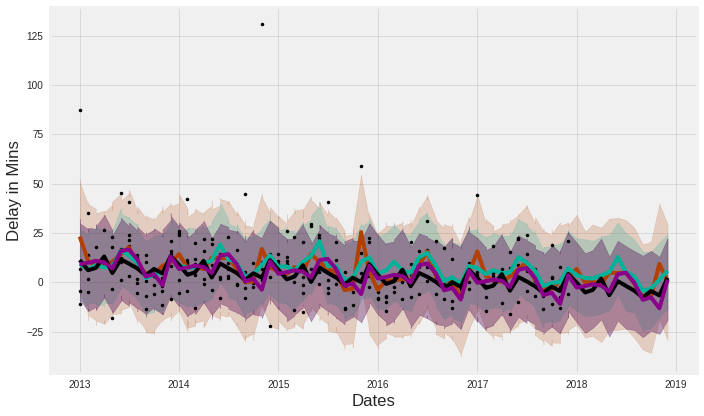

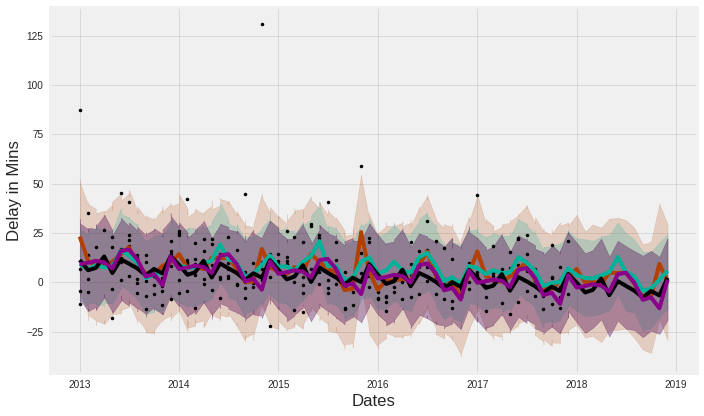

In [0]:
#Plots for delays
plot1(p_modelaustin, p_modeldfw, p_modelabq, p_modelBOSarr, forecastaustin, forecastdfw, forecastabq, forecastBOS)



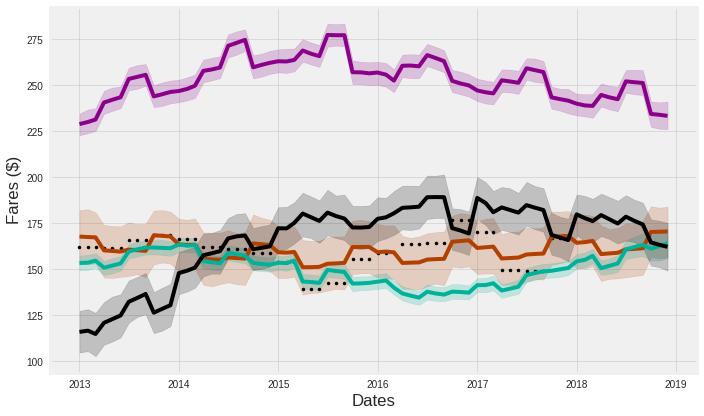

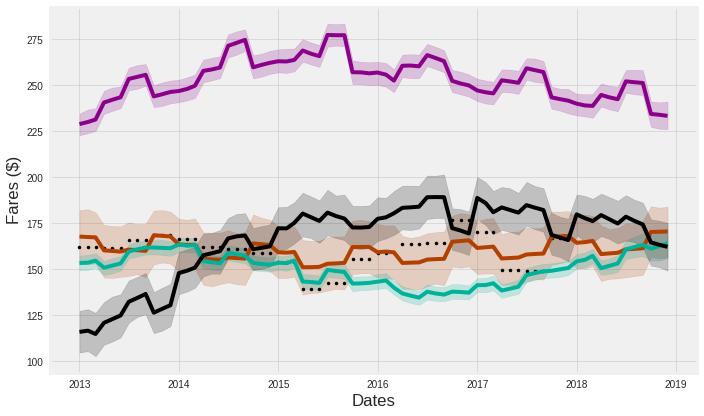

In [0]:
#plots for fares

def plot2(
    m, m1, m2, m3, fcst, fcst1, fcst2, fcst3, ax=None, uncertainty=True, plot_cap=True, xlabel='Dates', ylabel='Fares ($)',
    figsize=(10, 6)
):
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds'].dt.to_pydatetime()
    fcst_1 = fcst1['ds'].dt.to_pydatetime()
    fcst_2 = fcst2['ds'].dt.to_pydatetime()
    fcst_3 = fcst3['ds'].dt.to_pydatetime()
     
  
  
    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.')
    ax.plot(fcst_t, fcst['yhat'], ls='-', c='#b24000')
    ax.plot(fcst_1, fcst1['yhat'], ls='-', c='#00b299')    
    ax.plot(fcst_2, fcst2['yhat'], ls='-', c='#000000') 
    ax.plot(fcst_3, fcst3['yhat'], ls='-', c='#8B008B') 
       
    

    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k')
        ax.plot(fcst_1, fcst1['cap'], ls='--', c='k')
        ax.plot(fcst_2, fcst2['cap'], ls='--', c='k', linestyle=':')
        ax.plot(fcst_3, fcst3['cap'], ls='--', c='k', linestyle=':')
        
    
    
    
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k')
        ax.plot(fcst_1, fcst1['floor'], ls='--', c='k')
        ax.plot(fcst_2, fcst2['floor'], ls='--', c='k',  linestyle=':')
        ax.plot(fcst_3, fcst3['floor'], ls='--', c='k',  linestyle=':')
   
  
  
  
        
    if uncertainty:
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'], color='#b24000', alpha=0.2)
        ax.fill_between(fcst_1, fcst1['yhat_lower'], fcst1['yhat_upper'], color='#00b299', alpha=0.2)
        ax.fill_between(fcst_2, fcst2['yhat_lower'], fcst2['yhat_upper'], color='#000000', alpha=0.2)
        ax.fill_between(fcst_3, fcst3['yhat_lower'], fcst3['yhat_upper'], color='#8B008B', alpha=0.2)
  
  
  
  
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    return fig


plot2(p_modelausfares, p_modeldfwfares, p_modelabqfares, p_modelbosfares, forecastausfares, forecastdfwfares, forecastabqfares, forecastbosfares)


In [0]:
Fares_DelaysDF.head()

,YEAR,QUARTER,ORIGIN_CITY_NAME,DEST_CITY_NAME,FARES,MONTH,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Delay
0,2013,1,"Albuquerque, NM","Denver, CO",122.91,1,EV,10140,11292,-2.285714,0.142857,-3.142857,0.142857,0.000000,0.000000,0.142857,0.0,2.428571,no
1,2013,1,"Albuquerque, NM","Denver, CO",122.91,1,F9,10140,11292,7.800000,0.200000,5.600000,0.200000,0.000000,0.000000,0.000000,0.0,7.400000,yes
2,2013,1,"Albuquerque, NM","Denver, CO",122.91,1,OO,10140,11292,9.611111,0.250000,7.805556,0.222222,0.166667,0.000000,0.388889,0.0,9.805556,yes
3,2013,1,"Albuquerque, NM","Denver, CO",122.91,1,WN,10140,11292,4.142857,0.142857,1.666667,0.154762,0.261905,0.166667,2.452381,0.0,1.845238,yes
4,2013,1,"Albuquerque, NM","Denver, CO",122.91,2,EV,10140,11292,7.470588,0.235294,6.470588,0.235294,3.176471,0.000000,1.764706,0.0,5.647059,yes


In [0]:
#Setup for AUS Gradient 



#Setup for Austin Gradient 

aus = Fares_DelaysDF[Fares_DelaysDF['ORIGIN_CITY_NAME'] == "Austin, TX"]
ausx = aus['FARES']
ausy = aus['ARR_DELAY']

x=ausx
y=ausy

x = (x - x.mean()) / x.std()
x = np.c_[np.ones(x.shape[0]), x] 

Gradient Descent: 0.76, 0.28
Gradient Descent: 0.81, 0.27
Gradient Descent: 0.87, 0.26
Gradient Descent: 0.93, 0.26
Gradient Descent: 0.99, 0.25
Gradient Descent: 1.04, 0.24
Gradient Descent: 1.10, 0.23
Gradient Descent: 1.15, 0.23
Gradient Descent: 1.21, 0.22
Gradient Descent: 1.26, 0.21
Gradient Descent: 1.31, 0.20
Gradient Descent: 1.37, 0.20
Gradient Descent: 1.42, 0.19
Gradient Descent: 1.47, 0.18
Gradient Descent: 1.52, 0.18
Gradient Descent: 1.57, 0.17
Gradient Descent: 1.62, 0.16
Gradient Descent: 1.67, 0.16
Gradient Descent: 1.72, 0.15
Gradient Descent: 1.77, 0.14
Gradient Descent: 1.82, 0.14
Gradient Descent: 1.87, 0.13
Gradient Descent: 1.91, 0.13
Gradient Descent: 1.96, 0.12
Gradient Descent: 2.01, 0.11
Gradient Descent: 2.05, 0.11
Gradient Descent: 2.10, 0.10
Gradient Descent: 2.14, 0.09
Gradient Descent: 2.19, 0.09
Gradient Descent: 2.23, 0.08
Gradient Descent: 2.28, 0.08
Gradient Descent: 2.32, 0.07
Gradient Descent: 2.36, 0.07
Gradient Descent: 2.40, 0.06
Gradient Desce

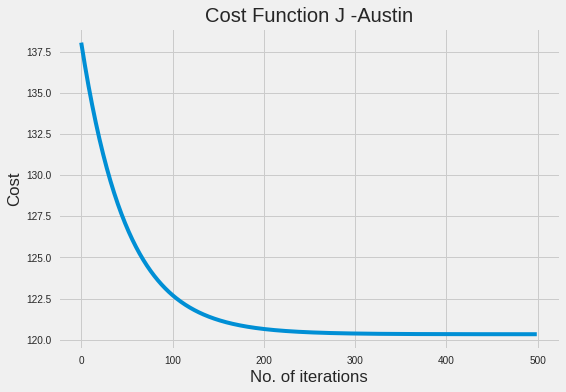

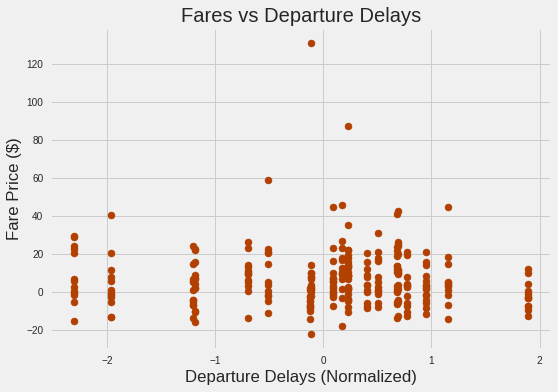

In [0]:


#GRADIENT DESCENT


alpha = 0.01 #Step size
iterations = 500 #No. of iterations
m = y.size #No. of data points
np.random.seed(123) #Set the seed
theta = np.random.rand(2) #Pick some random values to start with


#GRADIENT DESCENT
def gradient_descent(x, y, theta, iterations, alpha):
    past_costs = []
    past_thetas = [theta]
    for i in range(iterations):
        prediction = np.dot(x, theta)
        error = prediction - y
        cost = 1/(2*m) * np.dot(error.T, error)
        past_costs.append(cost)
        theta = theta - (alpha * (1/m) * np.dot(x.T, error))
        past_thetas.append(theta)
        print("Gradient Descent: {:.2f}, {:.2f}".format(theta[0], theta[1]))  # we can take this out, just shows the progression on the descent and when it stops descending
        
    return past_thetas, past_costs

#Pass the relevant variables to the function and get the new values back...
past_thetas, past_costs = gradient_descent(x, y, theta, iterations, alpha)
theta = past_thetas[-1]

#Print the results...
print("Gradient Descent: {:.2f}, {:.2f}".format(theta[0], theta[1]))

plt.title('Cost Function J -Austin')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(past_costs)
plt.show()

#Set the plot up,
fig = plt.figure()
ax = plt.axes()
plt.title('Fares vs Departure Delays')
plt.xlabel('Departure Delays (Normalized)')
plt.ylabel('Fare Price ($)')
plt.scatter(x[:,1], y, color='#b24000')
line, = ax.plot([], [], lw=2)
plt.show()






Gradient Descent: 6.57, -0.48
Gradient Descent: 6.58, -0.47
Gradient Descent: 6.60, -0.46
Gradient Descent: 6.61, -0.45
Gradient Descent: 6.62, -0.44
Gradient Descent: 6.64, -0.43
Gradient Descent: 6.65, -0.42
Gradient Descent: 6.66, -0.41
Gradient Descent: 6.67, -0.40
Gradient Descent: 6.69, -0.40
Gradient Descent: 6.70, -0.39
Gradient Descent: 6.71, -0.38
Gradient Descent: 6.72, -0.37
Gradient Descent: 6.73, -0.36
Gradient Descent: 6.75, -0.35
Gradient Descent: 6.76, -0.34
Gradient Descent: 6.77, -0.33
Gradient Descent: 6.78, -0.33
Gradient Descent: 6.79, -0.32
Gradient Descent: 6.80, -0.31
Gradient Descent: 6.81, -0.30
Gradient Descent: 6.82, -0.29
Gradient Descent: 6.84, -0.29
Gradient Descent: 6.85, -0.28
Gradient Descent: 6.86, -0.27
Gradient Descent: 6.87, -0.26
Gradient Descent: 6.88, -0.26
Gradient Descent: 6.89, -0.25
Gradient Descent: 6.90, -0.24
Gradient Descent: 6.91, -0.23
Gradient Descent: 6.92, -0.23
Gradient Descent: 6.93, -0.22
Gradient Descent: 6.94, -0.21
Gradient D

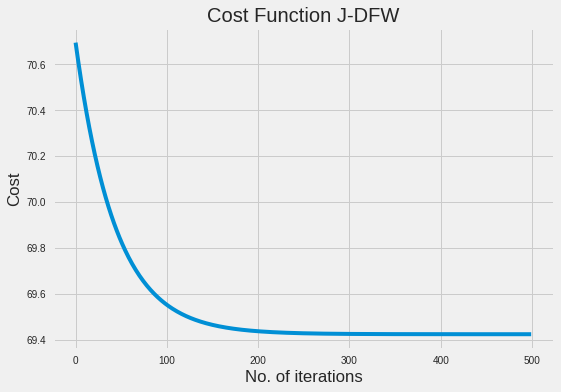

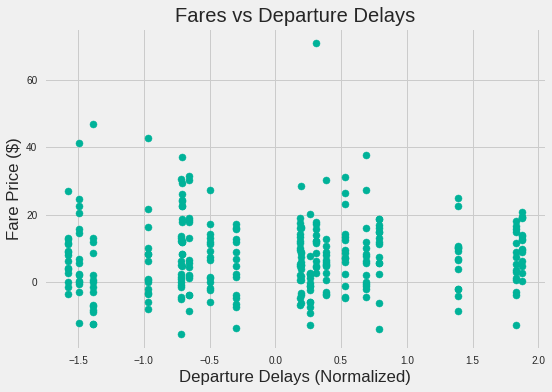

In [0]:

#Gradient Regression Model - DFW

dfw = Fares_DelaysDF[Fares_DelaysDF['ORIGIN_CITY_NAME'] == "Dallas/Fort Worth, TX"]
dfwx = dfw['FARES']
dfwy = dfw['ARR_DELAY']


x=dfwx
y=dfwy

x = (x - x.mean()) / x.std()
x = np.c_[np.ones(x.shape[0]), x] 





#Pass the relevant variables to the function and get the new values back...
past_thetas, past_costs = gradient_descent(x, y, theta, iterations, alpha)
theta = past_thetas[-1]

#Print the results...
print("Gradient Descent: {:.2f}, {:.2f}".format(theta[0], theta[1]))

plt.title('Cost Function J-DFW')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(past_costs)
plt.show()

#Set the plot up,
fig = plt.figure()
ax = plt.axes()
plt.title('Fares vs Departure Delays')
plt.xlabel('Departure Delays (Normalized)')
plt.ylabel('Fare Price ($)')
plt.scatter(x[:,1], y, color='#00b299')
line, = ax.plot([], [], lw=2)
plt.show()


Gradient Descent: 7.72, 0.37
Gradient Descent: 7.70, 0.35
Gradient Descent: 7.67, 0.32
Gradient Descent: 7.64, 0.30
Gradient Descent: 7.61, 0.28
Gradient Descent: 7.58, 0.25
Gradient Descent: 7.56, 0.23
Gradient Descent: 7.53, 0.21
Gradient Descent: 7.50, 0.18
Gradient Descent: 7.47, 0.16
Gradient Descent: 7.45, 0.14
Gradient Descent: 7.42, 0.12
Gradient Descent: 7.39, 0.10
Gradient Descent: 7.37, 0.08
Gradient Descent: 7.34, 0.05
Gradient Descent: 7.32, 0.03
Gradient Descent: 7.29, 0.01
Gradient Descent: 7.27, -0.01
Gradient Descent: 7.24, -0.03
Gradient Descent: 7.22, -0.05
Gradient Descent: 7.19, -0.07
Gradient Descent: 7.17, -0.09
Gradient Descent: 7.14, -0.11
Gradient Descent: 7.12, -0.13
Gradient Descent: 7.09, -0.15
Gradient Descent: 7.07, -0.17
Gradient Descent: 7.05, -0.19
Gradient Descent: 7.02, -0.21
Gradient Descent: 7.00, -0.23
Gradient Descent: 6.98, -0.25
Gradient Descent: 6.96, -0.27
Gradient Descent: 6.93, -0.28
Gradient Descent: 6.91, -0.30
Gradient Descent: 6.89, -0.

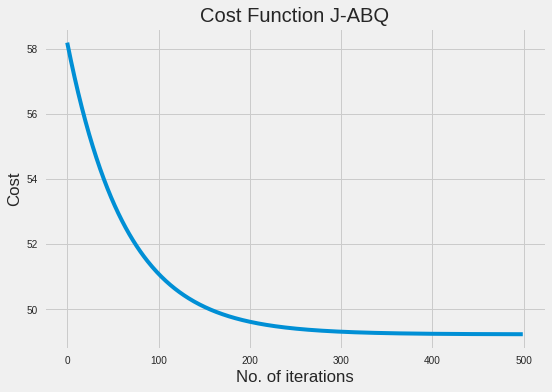

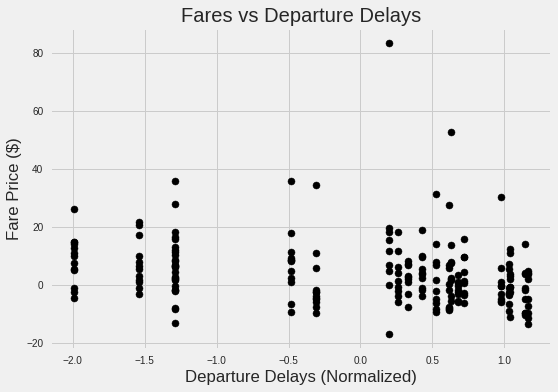

In [0]:

#Setup for ABQ Gradient 

abq = Fares_DelaysDF[Fares_DelaysDF['ORIGIN_CITY_NAME'] == "Albuquerque, NM"]
abqx = abq['FARES']
abqy = abq['ARR_DELAY']

x=abqx
y=abqy

x = (x - x.mean()) / x.std()
x = np.c_[np.ones(x.shape[0]), x] 


#Pass the relevant variables to the function and get the new values back...
past_thetas, past_costs = gradient_descent(x, y, theta, iterations, alpha)
theta = past_thetas[-1]

#Print the results...
print("Gradient Descent: {:.2f}, {:.2f}".format(theta[0], theta[1]))

plt.title('Cost Function J-ABQ')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(past_costs)
plt.show()

#Set the plot up,
fig = plt.figure()
ax = plt.axes()
plt.title('Fares vs Departure Delays')
plt.xlabel('Departure Delays (Normalized)')
plt.ylabel('Fare Price ($)')
plt.scatter(x[:,1], y, color='black')
line, = ax.plot([], [], lw=2)
plt.show()




     YEAR  QUARTER                ORIGIN_CITY_NAME DEST_CITY_NAME   FARES  \
24   2013        1  Boston, MA (Metropolitan Area)     Denver, CO  230.13   
25   2013        1  Boston, MA (Metropolitan Area)     Denver, CO  230.13   
26   2013        1  Boston, MA (Metropolitan Area)     Denver, CO  230.13   
27   2013        1  Boston, MA (Metropolitan Area)     Denver, CO  230.13   
28   2013        1  Boston, MA (Metropolitan Area)     Denver, CO  230.13   
29   2013        1  Boston, MA (Metropolitan Area)     Denver, CO  230.13   
30   2013        1  Boston, MA (Metropolitan Area)     Denver, CO  230.13   
31   2013        1  Boston, MA (Metropolitan Area)     Denver, CO  230.13   
32   2013        1  Boston, MA (Metropolitan Area)     Denver, CO  230.13   
75   2013        2  Boston, MA (Metropolitan Area)     Denver, CO  239.31   
76   2013        2  Boston, MA (Metropolitan Area)     Denver, CO  239.31   
77   2013        2  Boston, MA (Metropolitan Area)     Denver, CO  239.31   

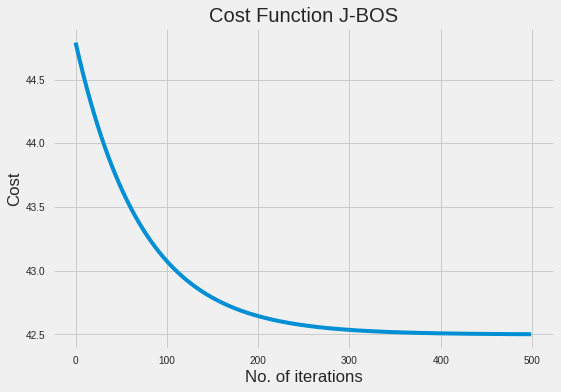

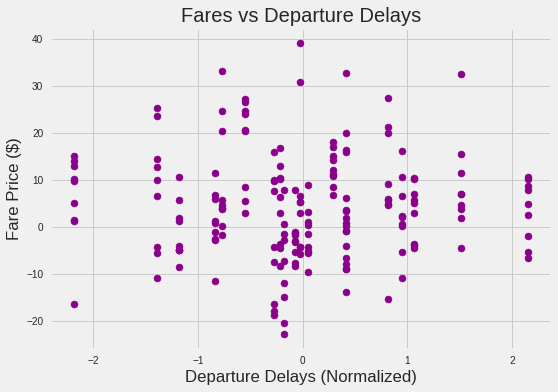

In [0]:
#Setup for BOS Gradient 

bos = Fares_DelaysDF[Fares_DelaysDF['ORIGIN_CITY_NAME'] == "Boston, MA (Metropolitan Area)"]
bosx = bos['FARES']
bosy = bos['ARR_DELAY']

x=bosx
y=bosy

x = (x - x.mean()) / x.std()
x = np.c_[np.ones(x.shape[0]), x] 

print(bos)


#Pass the relevant variables to the function and get the new values back...
past_thetas, past_costs = gradient_descent(x, y, theta, iterations, alpha)
theta = past_thetas[-1]

#Print the results...
print("Gradient Descent: {:.2f}, {:.2f}".format(theta[0], theta[1]))

plt.title('Cost Function J-BOS')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(past_costs)
plt.show()

#Set the plot up,
fig = plt.figure()
ax = plt.axes()
plt.title('Fares vs Departure Delays')
plt.xlabel('Departure Delays (Normalized)')
plt.ylabel('Fare Price ($)')
plt.scatter(x[:,1], y, color='#8B008B')
line, = ax.plot([], [], lw=2)
plt.show()




In [0]:
#Optimization
#Fares Output



forecastsausfares = forecastausfares[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecastdfwfares= forecastdfwfares[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecastabqfares= forecastabqfares[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecastbosfares= forecastbosfares[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

frames = [forecastsaus, forecastdfwfares, forecastabqfares,forecastbosfares]
combined = pd.concat(frames)






In [0]:
forecastaustin[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,23.216566,-7.763387,50.674327
1,2013-01-01,23.216566,-5.037024,51.788707
2,2013-01-01,23.216566,-4.242753,51.772831
3,2013-01-01,23.216566,-4.320468,50.553149
4,2013-02-01,10.814768,-16.175536,39.371442
5,2013-02-01,10.814768,-16.991011,40.701257
6,2013-02-01,10.814768,-19.263904,39.691118
7,2013-02-01,10.814768,-16.564537,39.550998
8,2013-03-01,8.169172,-19.221041,37.249845
9,2013-03-01,8.169172,-21.118673,36.480382


In [0]:
#Create a dataframe for the forecasts combining all cities

forecastaustindelays = forecastaustin[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecastdfwdelays = forecastdfw[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecastabqdelays = forecastabq[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecastBOSdelays = forecastBOS[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

frames1 = [forecastaustindelays, forecastaustindelays, forecastabqdelays,forecastBOSdelays]

combined1 = pd.concat(frames1)


In [0]:
#Write out the CSVs
combined.to_csv("combined.csv")
combined1.to_csv("combined1.csv")
